In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from timeit import default_timer


In [3]:

ratings = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/rating.csv')
movies = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/movie.csv')

In [4]:
df_movies = movies 
df_ratings = ratings

# EDA 

In [5]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movieId', inplace=True)
ratings.sort_values(by='movieId', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    

C:\Users\HP\AppData\Local\Temp\ipykernel_2224\1341862291.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)


Number of movies Null values:  22
Number of ratings Null values:  0


In [5]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27256 entries, 0 to 27255
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieId             27256 non-null  int64  
 1   title               27256 non-null  object 
 2   year                27256 non-null  float64
 3   (no genres listed)  27256 non-null  bool   
 4   Action              27256 non-null  bool   
 5   Adventure           27256 non-null  bool   
 6   Animation           27256 non-null  bool   
 7   Children            27256 non-null  bool   
 8   Comedy              27256 non-null  bool   
 9   Crime               27256 non-null  bool   
 10  Documentary         27256 non-null  bool   
 11  Drama               27256 non-null  bool   
 12  Fantasy             27256 non-null  bool   
 13  Film-Noir           27256 non-null  bool   
 14  Horror              27256 non-null  bool   
 15  IMAX                27256 non-null  bool   
 16  Musi

# Average ratings per user. 

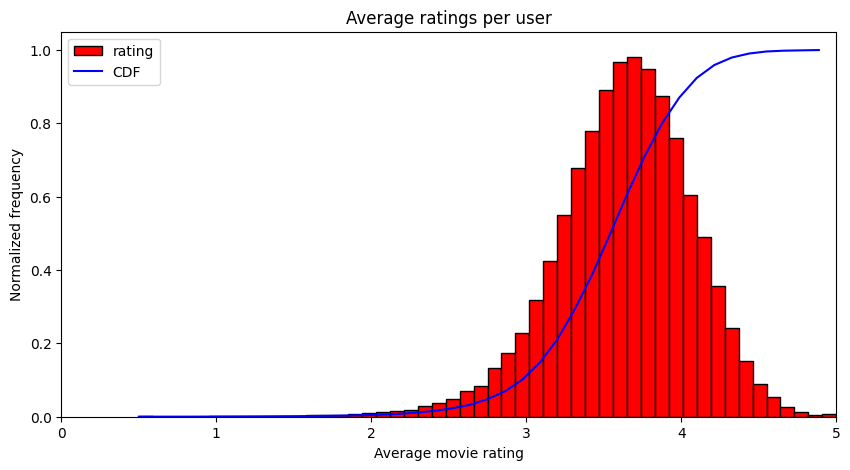

Elapsed time(sec):  1.44


In [8]:

st = default_timer()

dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=False, density=True, color='red', edgecolor='black', figsize=(10, 5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^base$|^cumulative$|^values$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

# Ratings per movie.

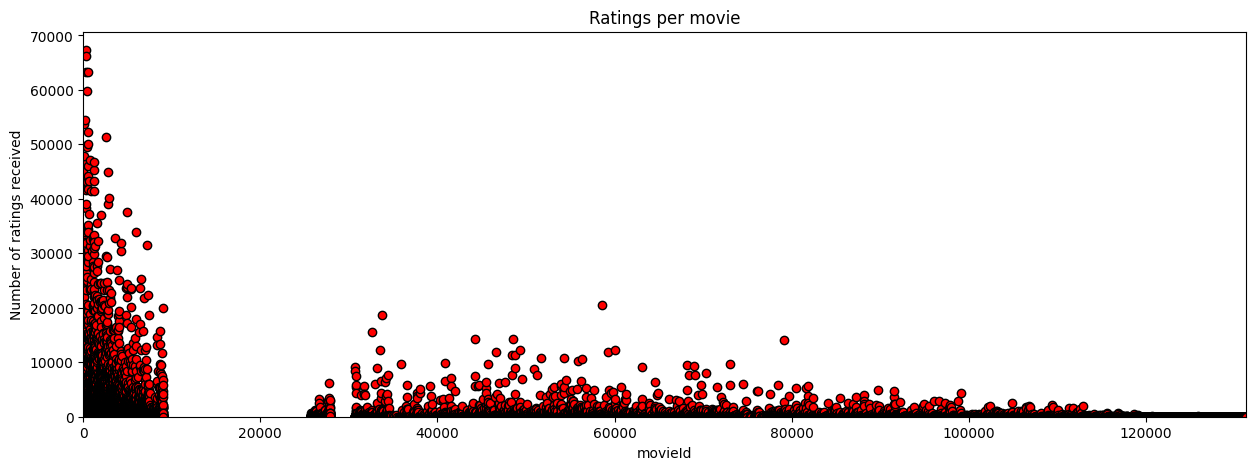

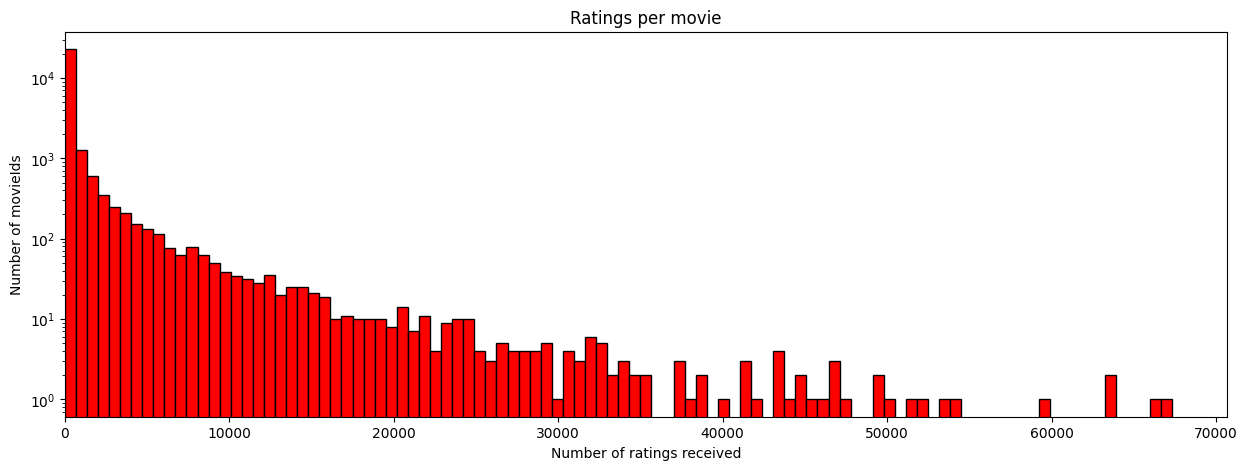

In [9]:

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black', color = 'red')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', color = 'red', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()


# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()

# Housekeeping
%reset_selective -f (^dftmp$|^tmp$)


# Average rating for all individual movies. 

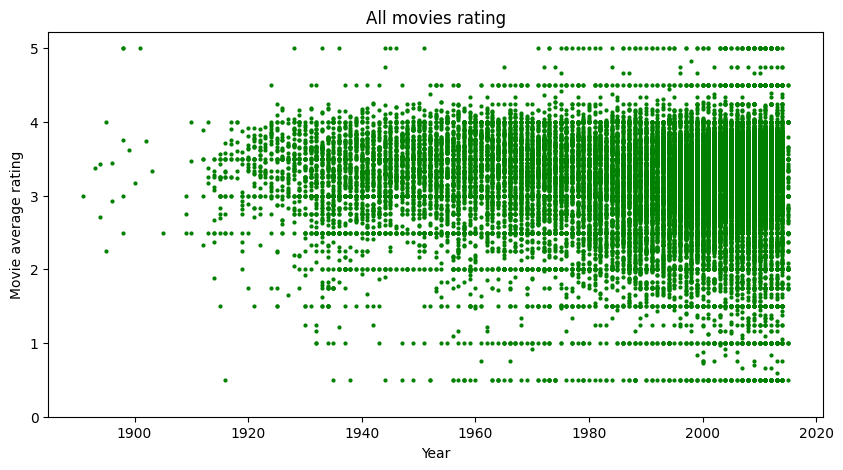

Elapsed time(sec):  0.64


In [10]:
st = default_timer()

dftmp = movies[['movieId', 'year']].set_index('movieId').join(
    ratings[['movieId','rating']].groupby('movieId').mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Year')
plt.ylabel('Movie average rating')
plt.title('All movies rating')
plt.ylim(0,)
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

In [11]:
# Reinitialising variables
movies = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/movie.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['movieId','title','genres'] )
ratings = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/rating.csv',nrows = 1000000,sep=',', encoding='latin-1',usecols=['userId','movieId','rating','timestamp'])
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())
#additional temporary variable
df_movies1 = movies 
df_ratings1 = ratings

## Most popular genres of movie released

<BarContainer object of 19 artists>

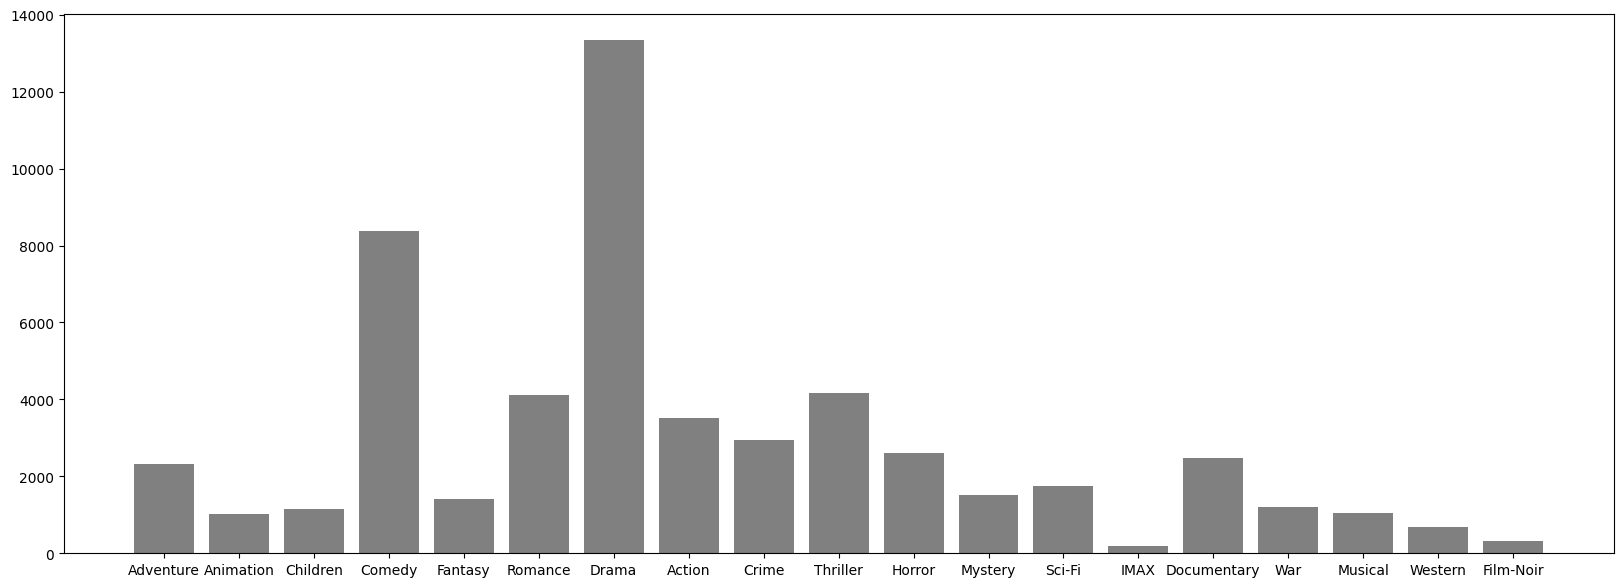

In [13]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(), color = 'grey')

## distribution of users rating

In [14]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [15]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1000000.000000
mean           3.526803
std            1.052167
min            0.500000
25%            3.000000
50%            4.000000
75%            4.000000
max            5.000000
Name: rating, dtype: float64

C:\Users\HP\AppData\Local\Temp\ipykernel_2224\296977727.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ratings["rating"], color = 'grey')


<Axes: xlabel='rating', ylabel='Density'>

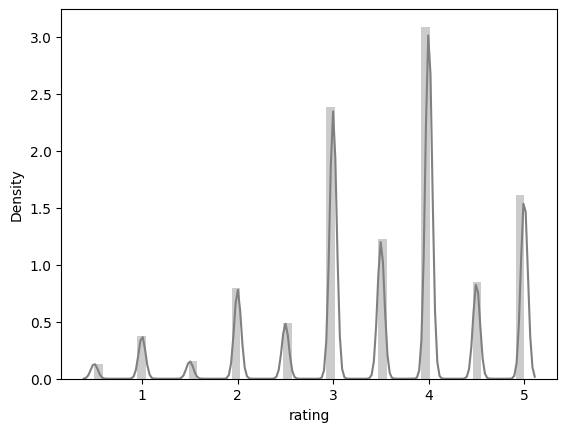

In [16]:
sns.distplot(df_ratings["rating"], color = 'grey')

In [20]:
# Grouping the rating based on user and aggregating by count and mean
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg(
    rating_count=('rating', 'size'), 
    rating_mean=('rating', 'mean')
)

# Display the first 10 rows
ratings_grouped_by_users.head(10)


,rating_count,rating_mean
userId,,
1,175,3.742857
2,61,4.000000
3,187,4.122995
4,28,3.571429
5,66,4.272727
6,24,3.750000
7,276,3.289855
8,70,3.800000
9,35,3.057143


## Top 10 users who have rated most of the movies

<Axes: xlabel='userId'>

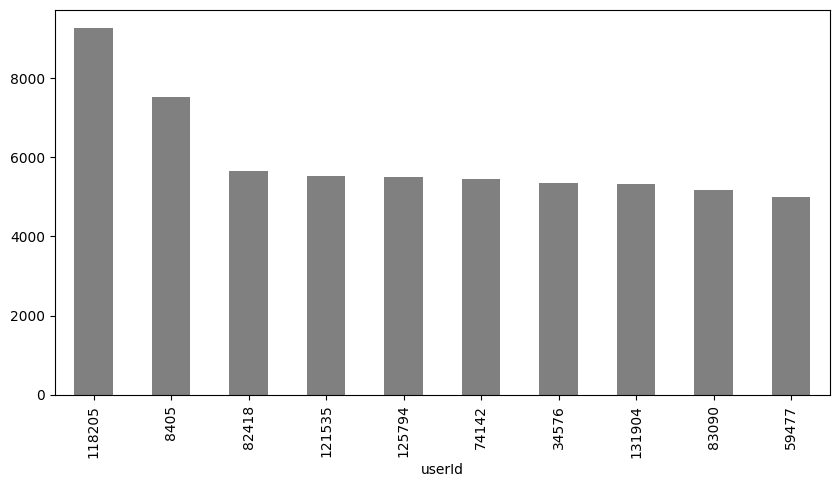

In [22]:
ratings_grouped_by_users['rating_count'].sort_values(ascending=False).head(10).plot(
    kind='bar', figsize=(10, 5), color='grey'
)


In [23]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg(
    rating_mean=('rating', 'mean'), 
    rating_count=('rating', 'size')
)


In [24]:
ratings_grouped_by_movies.shape

(26744, 2)

In [26]:
# Drop 'userId' if it exists
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1, errors='ignore')


# movies with average rating

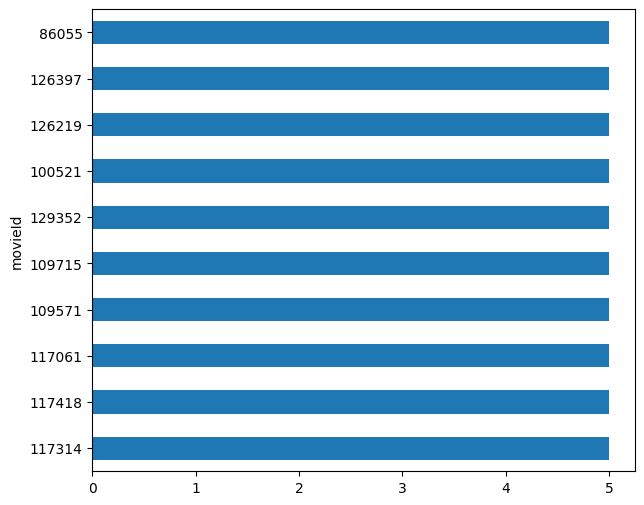

In [28]:
ratings_grouped_by_movies['rating_mean'].sort_values(ascending=False).head(10).plot(
    kind='barh', figsize=(7, 6)
);


# Movies with low average rating

<Axes: ylabel='movieId'>

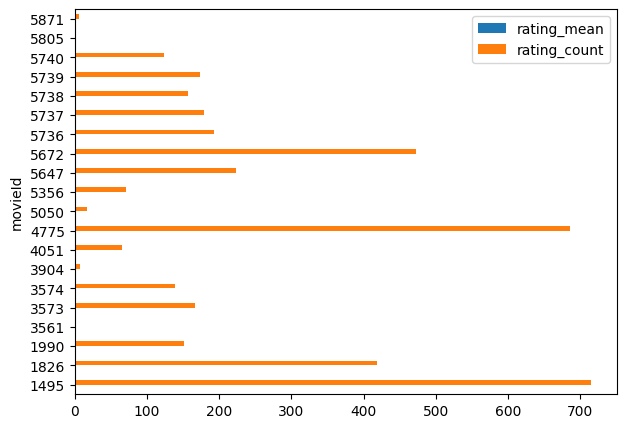

In [29]:
# Filter movies with an average rating below 1.5
low_rated_movies_filter = ratings_grouped_by_movies['rating_mean'] < 1.5
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

# Plot the top 20 low-rated movies
low_rated_movies.head(20).plot(kind='barh', figsize=(7, 5))


# Collaborative Filtering

# Model-Based Collaborative Filtering

## Matrix factorisation for performing data decomposition technique

In [30]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/rating.csv',nrows = 1000000)

# Reading movies file
movies = pd.read_csv('C:/Users/HP/Python/Movie Recomender Systen/Dataset/movie.csv',nrows = 1000000)
movies['year'] = movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies['year'] = movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
movies['title'] = movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [31]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6743 | Number of movies = 13950


Now we want the format of our ratings matrix to be one row per user and one column per movie. To do so, we willl pivot ratings to get that and call the new variable Ratings (with a capital *R).

In [32]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, we need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [33]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

6743


In [34]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens dataset is 98.9%



## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. We are going to use the Scipy function svds because it let us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [35]:
from scipy.sparse.linalg import svds

In [36]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


converting summation to diagonal matrix 

In [37]:
sigma = np.diag(sigma)

In [38]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 142.61249165    0.            0.         ...    0.
     0.            0.        ]
 [   0.          143.85301215    0.         ...    0.
     0.            0.        ]
 [   0.            0.          144.52622401 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  614.79347143
     0.            0.        ]
 [   0.            0.            0.         ...    0.
   656.79707909    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1560.07209886]]


In [39]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (6743, 50)
Shape of Vt:  (50, 13950)


##  Making Predictions from the Decomposed Matrices

In [40]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [41]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (6743, 13950)


In [42]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,129350,129354,129428,129707,130052,130073,130219,130462,130490,130642
0,0.462816,0.886560,0.116673,0.008308,-0.215565,0.110520,-0.358674,-0.024280,-0.217334,0.032192,...,0.007858,-0.009063,-0.000590,-0.002358,-0.003434,0.002593,-0.008268,-0.010008,0.003211,-0.005214
1,0.979778,0.101947,0.331502,0.084563,0.198166,0.225804,0.464224,-0.000231,0.089829,-0.063064,...,-0.002574,-0.007137,-0.005901,-0.000340,-0.000661,0.005147,-0.003343,0.003982,0.007401,-0.000236
2,2.042083,0.828816,-0.159202,-0.011740,-0.123303,0.469264,0.055829,0.002462,-0.053686,0.352812,...,0.003774,0.014084,0.007017,0.004093,0.003028,0.027928,-0.001567,0.006333,0.009272,0.001203
3,-0.527892,0.673756,0.420112,0.001046,0.276751,0.840723,0.090925,0.090294,0.186957,0.946194,...,0.001692,0.001809,0.001136,0.002849,0.001862,0.000747,0.002181,0.002332,0.004352,0.000067
4,2.246131,1.121891,1.234257,0.115929,1.183925,0.619121,1.367333,0.157426,0.296183,1.433395,...,-0.000493,0.009807,-0.009911,0.001258,0.001165,0.002508,0.000942,0.001017,0.007514,0.002189


In [43]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [49]:
already_rated, predictions = recommend_movies(preds, 152, movies, ratings, 20)

User 152 has already rated 154 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [50]:
# Top 20 movies that User 150 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres,year
3,152,39,5.0,2006-10-18 23:57:43,Clueless (1995),Comedy|Romance,1995
12,152,231,5.0,2006-10-18 23:55:47,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,1994
91,152,4034,5.0,2006-10-18 23:56:05,Traffic (2000),Crime|Drama|Thriller,2000
97,152,4995,5.0,2006-10-18 23:54:58,"Beautiful Mind, A (2001)",Drama|Romance,2001
101,152,5669,5.0,2006-10-18 23:55:18,Bowling for Columbine (2002),Documentary,2002
80,152,2959,5.0,2006-10-18 23:55:16,Fight Club (1999),Action|Crime|Drama|Thriller,1999
68,152,2291,5.0,2006-10-18 23:57:22,Edward Scissorhands (1990),Drama|Fantasy|Romance,1990
75,152,2762,5.0,2006-10-18 23:56:15,"Sixth Sense, The (1999)",Drama|Horror|Mystery,1999
33,152,592,5.0,2006-10-18 23:53:51,Batman (1989),Action|Crime|Thriller,1989
29,152,586,5.0,2006-10-18 23:58:01,Home Alone (1990),Children|Comedy,1990


In [51]:
# Top 20 movies that User 20 hopefully will enjoy
predictions

,movieId,title,genres,year
2526,2683,Austin Powers: The Spy Who Shagged Me (1999),Action|Adventure|Comedy,1999
3615,3793,X-Men (2000),Action|Adventure|Sci-Fi,2000
2416,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1567,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi,1998
5248,5445,Minority Report (2002),Action|Crime|Mystery|Sci-Fi|Thriller,2002
28,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,1995
3812,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,2000
506,539,Sleepless in Seattle (1993),Comedy|Drama|Romance,1993
6129,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller,2003


# Model Evaluation

In [52]:
# Import necessary libraries for evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# Get all actual user ratings and predicted ratings into a DataFrame for comparison
def get_predicted_actual_ratings(preds, ratings):
    # Convert predictions DataFrame to a matrix format to allow easy comparison with actual ratings
    pred_ratings_flattened = preds.values.flatten()
    
    # Reshape the actual ratings matrix to match the flattened predictions matrix
    ratings_flattened = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0).values.flatten()
    
    # Create DataFrame to store both predictions and actual ratings
    evaluation_df = pd.DataFrame({
        'Actual': ratings_flattened,
        'Predicted': pred_ratings_flattened
    })
    # Filter out pairs where there is no rating
    evaluation_df = evaluation_df[evaluation_df['Actual'] != 0]
    return evaluation_df

# Function to calculate evaluation metrics
def evaluate_model(predictions_df):
    # Calculate RMSE (Root Mean Squared Error)
    rmse = sqrt(mean_squared_error(predictions_df['Actual'], predictions_df['Predicted']))
    print("Root Mean Squared Error (RMSE):", rmse)
    
    # Calculate sparsity
    sparsity = round(1.0 - len(predictions_df) / float(n_users * n_movies), 3)
    print("Sparsity level:", sparsity * 100, '%')
    
    # Metrics like Precision@K and Recall@K are specific to top-k recommendations.
    # Here we can implement Precision@K for the top 10 recommended movies.
    precision_at_k, recall_at_k = precision_recall_k(preds, ratings, k=10)
    print("Precision@10:", precision_at_k)
    print("Recall@10:", recall_at_k)

# Function to calculate Precision@K and Recall@K
def precision_recall_k(preds, ratings, k=10):
    precision_total, recall_total = 0, 0
    for user in preds.index:
        # Sort user predictions for each user
        top_k_predictions = preds.loc[user].sort_values(ascending=False).index[:k]
        
        # Find actual rated movies by user
        actual_movies = ratings[ratings['userId'] == user]['movieId'].tolist()
        
        # Calculate hits (movies both recommended and rated)
        hits = len(set(top_k_predictions).intersection(set(actual_movies)))
        
        # Calculate Precision@K
        precision_at_k = hits / k
        # Calculate Recall@K
        recall_at_k = hits / len(actual_movies) if len(actual_movies) > 0 else 0
        
        precision_total += precision_at_k
        recall_total += recall_at_k
    
    # Calculate average Precision@K and Recall@K for all users
    avg_precision_at_k = precision_total / preds.shape[0]
    avg_recall_at_k = recall_total / preds.shape[0]
    return avg_precision_at_k, avg_recall_at_k

# Evaluate the model
predictions_df = get_predicted_actual_ratings(preds, ratings)
evaluate_model(predictions_df)


Root Mean Squared Error (RMSE): 2.373773178000841
Sparsity level: 98.9 %
Precision@10: 0.2890404864303686
Recall@10: 0.030332507209283606
